Source Credit: 

Data Source: https://www.kaggle.com/veleon/ham-and-spam-dataset
Code Credits: https://www.kaggle.com/sairam6087/chpt-3-hands-on-ml2-exercise-solutions-4


Plus a bit of modification here & there! Thank you!

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


%matplotlib inline

In [2]:
BASE_PATH = 'C:\\Users\\drrak\\Downloads\\Data Science Daily\\03-14-2020\\spam_detection'
HAM_DIR = os.path.join(BASE_PATH, "ham")
SPAM_DIR = os.path.join(BASE_PATH, "spam")

In [3]:
ham_filenames = [name for name in sorted(os.listdir(HAM_DIR)) if len(name) > 10]
spam_filenames = [name for name in sorted(os.listdir(SPAM_DIR)) if len(name) > 10]

print(len(ham_filenames))
print(len(spam_filenames))

2551
501


In [4]:
import email
import email.policy

In [5]:
def load_email(is_spam, filename, spam_path=BASE_PATH):
    directory = "spam" if is_spam else "ham"
    with open(os.path.join(spam_path, directory, filename), "rb") as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)

In [6]:
ham_emails = [load_email(is_spam=False, filename=name) for name in ham_filenames]
spam_emails = [load_email(is_spam=True, filename=name) for name in spam_filenames]

In [7]:
# ham
print(ham_emails[1].get_content().strip())

Martin A posted:
Tassos Papadopoulos, the Greek sculptor behind the plan, judged that the
 limestone of Mount Kerdylio, 70 miles east of Salonika and not far from the
 Mount Athos monastic community, was ideal for the patriotic sculpture. 
 
 As well as Alexander's granite features, 240 ft high and 170 ft wide, a
 museum, a restored amphitheatre and car park for admiring crowds are
planned
---------------------
So is this mountain limestone or granite?
If it's limestone, it'll weather pretty fast.

------------------------ Yahoo! Groups Sponsor ---------------------~-->
4 DVDs Free +s&p Join Now
http://us.click.yahoo.com/pt6YBB/NXiEAA/mG3HAA/7gSolB/TM
---------------------------------------------------------------------~->

To unsubscribe from this group, send an email to:
forteana-unsubscribe@egroups.com

 

Your use of Yahoo! Groups is subject to http://docs.yahoo.com/info/terms/


In [8]:
# spam 
print(spam_emails[6].get_content().strip())

A POWERHOUSE GIFTING PROGRAM You Don't Want To Miss! 
 
  GET IN WITH THE FOUNDERS! 
The MAJOR PLAYERS are on This ONE
For ONCE be where the PlayerS are
This is YOUR Private Invitation

EXPERTS ARE CALLING THIS THE FASTEST WAY 
TO HUGE CASH FLOW EVER CONCEIVED
Leverage $1,000 into $50,000 Over and Over Again

THE QUESTION HERE IS:
YOU EITHER WANT TO BE WEALTHY 
OR YOU DON'T!!!
WHICH ONE ARE YOU?
I am tossing you a financial lifeline and for your sake I 
Hope you GRAB onto it and hold on tight For the Ride of youR life!

Testimonials

Hear what average people are doing their first few days:
�We've received 8,000 in 1 day and we are doing that over and over again!' Q.S. in AL
 �I'm a single mother in FL and I've received 12,000 in the last 4 days.� D. S. in FL
�I was not sure about this when I sent off my $1,000 pledge, but I got back $2,000 the very next day!� L.L. in KY
�I didn't have the money, so I found myself a partner to work this with. We have received $4,000 over the last 2 days

### Split Data Set

In [9]:
from sklearn.model_selection import train_test_split

X = np.array(ham_emails + spam_emails)
y = np.array([0] * len(ham_emails) + [1] * len(spam_emails))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
import re
from html import unescape

def html_to_plain_text(html):
    text = re.sub('<head.*?>.*?</head>', '', html, flags=re.M | re.S | re.I)
    text = re.sub('<a\s.*?>', ' HYPERLINK ', text, flags=re.M | re.S | re.I)
    text = re.sub('<.*?>', '', text, flags=re.M | re.S)
    text = re.sub(r'(\s*\n)+', '\n', text, flags=re.M | re.S)
    return unescape(text)

def email_to_text(email):
    html = None
    for part in email.walk():
        ctype = part.get_content_type()
        if not ctype in ("text/plain", "text/html"):
            continue
        try:
            content = part.get_content()
        except: # in case of encoding issues
            content = str(part.get_payload())
        if ctype == "text/plain":
            return content
        else:
            html = content
    if html:
        return html_to_plain_text(html)

In [11]:
import nltk
stemmer = nltk.PorterStemmer()

from collections import Counter

import re
from sklearn.base import BaseEstimator, TransformerMixin

class EmailToWordCounterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, strip_headers=True, lower_case=True, remove_punctuation=True,
                 replace_urls=True, replace_numbers=True, stemming=True):
        self.strip_headers = strip_headers
        self.lower_case = lower_case
        self.remove_punctuation = remove_punctuation
        self.replace_urls = replace_urls
        self.replace_numbers = replace_numbers
        self.stemming = stemming
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_transformed = []
        for email in X:
            text = email_to_text(email) or ""
            if self.lower_case:
                text = text.lower()
            if self.replace_urls:
                urls = list(set(re.findall( r'(https?://\S+)' , text )))
                urls.sort(key=lambda url: len(url), reverse=True)
                for url in urls:
                    text = text.replace(url, " URL ")
            if self.replace_numbers:
                text = re.sub(r'\d+(?:\.\d*(?:[eE]\d+))?', 'NUMBER', text)
            if self.remove_punctuation:
                text = re.sub(r'\W+', ' ', text, flags=re.M)
            word_counts = Counter(text.split())
            if self.stemming and stemmer is not None:
                stemmed_word_counts = Counter()
                for word, count in word_counts.items():
                    stemmed_word = stemmer.stem(word)
                    stemmed_word_counts[stemmed_word] += count
                word_counts = stemmed_word_counts
            X_transformed.append(word_counts)
        return np.array(X_transformed)

In [12]:
from scipy.sparse import csr_matrix

class WordCounterToVectorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, vocabulary_size=1000):
        self.vocabulary_size = vocabulary_size
    def fit(self, X, y=None):
        total_count = Counter()
        for word_count in X:
            for word, count in word_count.items():
                total_count[word] += min(count, 10)
        most_common = total_count.most_common()[:self.vocabulary_size]
        self.most_common_ = most_common
        self.vocabulary_ = {word: index + 1 for index, (word, count) in enumerate(most_common)}
        return self
    def transform(self, X, y=None):
        rows = []
        cols = []
        data = []
        for row, word_count in enumerate(X):
            for word, count in word_count.items():
                rows.append(row)
                cols.append(self.vocabulary_.get(word, 0))
                data.append(count)
        solu = csr_matrix((data, (rows, cols)), shape=(len(X), self.vocabulary_size + 1))
        return solu

In [13]:
from sklearn.pipeline import Pipeline

preprocess_pipeline = Pipeline([
    ("email_to_wordcount", EmailToWordCounterTransformer()),
    ("wordcount_to_vector", WordCounterToVectorTransformer()),
])

X_train_transformed = preprocess_pipeline.fit_transform(X_train)

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

log_clf = LogisticRegression(solver="liblinear", random_state=42)
score = cross_val_score(log_clf, X_train_transformed, y_train, cv=3, verbose=3)
print('\nScores for all folds: ', score )
print('\nAverage Score: ', score.mean() )
print('\nStandard deviation of Scores: ', score.std() )

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV]  ................................................................
[CV] .................................... , score=0.987, total=   0.0s
[CV]  ................................................................
[CV] .................................... , score=0.993, total=   0.1s
[CV]  ................................................................
[CV] .................................... , score=0.985, total=   0.0s

Scores for all folds:  [0.98650307 0.99261993 0.98523985]

Average Score:  0.9881209486941495

Standard deviation of Scores:  0.0032227862719592134


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished


In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict

y_scores = cross_val_predict(log_clf, X_train_transformed, y_train, cv=3, method="decision_function")

from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

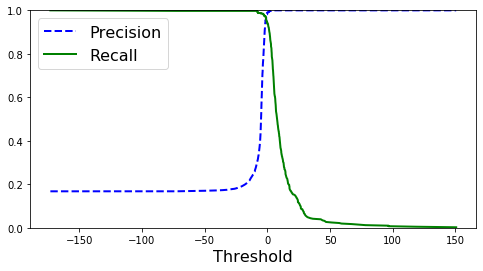

In [16]:
import matplotlib.pyplot as plt
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

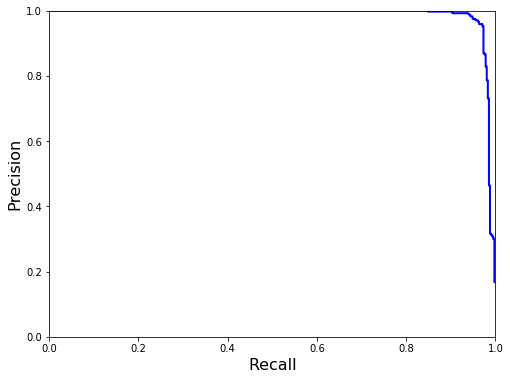

In [17]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

### Other Classification Algorithms

In [18]:
#from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import NearestNeighbors
from sklearn import tree

In [19]:
#lr=LogisticRegression(solver='liblinear')
nb=GaussianNB()
svm=SVC(kernel='rbf', gamma='auto')
nn=NearestNeighbors(n_neighbors=2)
dt=tree.DecisionTreeClassifier(max_depth=5)

In [20]:
#lr.fit(X_train_transformed,y_train)
nb.fit(X_train_transformed.toarray(),y_train)
svm.fit(X_train_transformed,y_train)
nn.fit(X_train_transformed,y_train)
dt.fit(X_train_transformed,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [21]:
X_test_transformed = preprocess_pipeline.transform(X_test)

In [22]:
#lr_predicted=lr.predict(X_test_transformed)
nb_predicted=nb.predict(X_test_transformed.toarray())
svm_predicted=svm.predict(X_test_transformed)
nn_predicted=nn.kneighbors(X_test_transformed)
dt_predicted=dt.predict(X_test_transformed)

In [24]:
#lr_cls_report=classification_report(y_test,lr_predicted)
svm_cls_report=classification_report(y_test,svm_predicted)
nb_cls_report=classification_report(y_test,nb_predicted)
dt_cls_report=classification_report(y_test,dt_predicted)
#print("Logistic regression : "+lr_cls_report)
print("SVM : "+svm_cls_report)
print("Naive Bayes : "+nb_cls_report)
print("Decision tree : "+dt_cls_report)

SVM :               precision    recall  f1-score   support

           0       0.96      1.00      0.98       519
           1       1.00      0.77      0.87        92

    accuracy                           0.97       611
   macro avg       0.98      0.89      0.93       611
weighted avg       0.97      0.97      0.96       611

Naive Bayes :               precision    recall  f1-score   support

           0       0.99      0.88      0.93       519
           1       0.59      0.93      0.72        92

    accuracy                           0.89       611
   macro avg       0.79      0.91      0.83       611
weighted avg       0.93      0.89      0.90       611

Decision tree :               precision    recall  f1-score   support

           0       0.96      0.99      0.98       519
           1       0.95      0.78      0.86        92

    accuracy                           0.96       611
   macro avg       0.95      0.89      0.92       611
weighted avg       0.96      0.96     